<a href="https://colab.research.google.com/github/Gholamrezadar/GAN-2D-data/blob/main/Approximate_a_2D_distribution_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

SEED = 69
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device: {device}")
print(f"torch version: {torch.__version__}")

device: cpu
torch version: 2.5.1+cu121


## Create the Data

In [ ]:
N = 10000
BATCH_SIZE = 64
Z_DIM = 16

In [ ]:
data.shape

(10000, 2)

In [ ]:
data = np.random.randn(N, 2)

# apply a linear transformation to the data
theta = 30 * np.pi / 180
scale_mat = np.array([
    [1.0/1, 0.0],
    [0.0, 1.0/2]
    ])
rot_mat = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
    ])
data = rot_mat @ scale_mat @ data.T
data = data.T

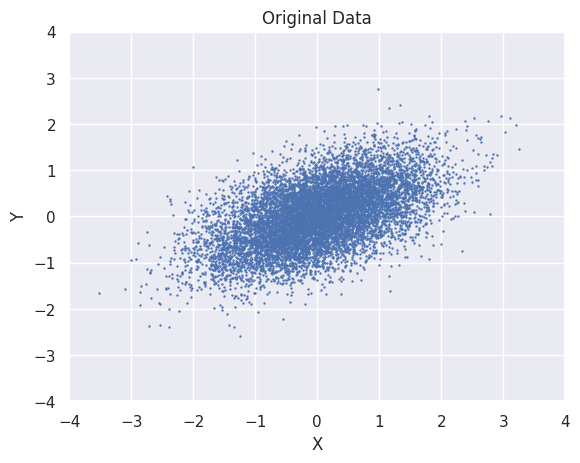

In [ ]:
plt.title("Original Data")
plt.scatter(data[:, 0], data[:, 1], s=0.5)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

data

In [ ]:
dataset = torch.utils.data.TensorDataset(torch.tensor(data, device=device, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# test the dataloader
next(iter(dataloader))[0][0].dtype

torch.float32

## Create the Model


In [ ]:
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim, device=device, dtype=torch.float32)

In [ ]:
get_noise(BATCH_SIZE, Z_DIM)

tensor([[-0.5300, -1.3035,  0.4438,  ...,  0.3527, -0.0916,  0.0341],
        [-0.8986,  0.1022, -0.6627,  ..., -1.8432,  0.8633, -1.7786],
        [-0.8080, -0.8735,  0.9367,  ..., -0.2034, -0.6882, -0.0178],
        ...,
        [ 1.6201,  0.1244, -0.2401,  ..., -1.0485, -2.0453, -0.2630],
        [-0.6295, -1.9538, -0.7165,  ..., -0.5206, -0.7322, -2.2723],
        [ 1.1720,  0.2896, -0.1449,  ..., -1.2649,  0.7716, -2.0717]])

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=16):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 2),
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 1)
            # No sigmoid in order to use BCEWithLogitsLoss for numerical stability
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
# testing gen and disc
test_gen = Generator(z_dim=Z_DIM)
test_disc = Discriminator()

In [ ]:
from torchsummary import summary

print("Generator Summary:")
summary(test_gen, (Z_DIM,))

print("\nDiscriminator Summary:")
summary(test_disc, (2,))

Generator Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             544
       BatchNorm1d-2                   [-1, 32]              64
              ReLU-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
              ReLU-6                   [-1, 16]               0
            Linear-7                    [-1, 2]              34
Total params: 1,202
Trainable params: 1,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------

Discriminator Summary:
----------------------------------------------------------------
  

In [ ]:
test_disc(test_gen(get_noise(4, 16)))

tensor([[-0.1873],
        [ 0.0364],
        [ 0.1544],
        [ 0.2178]], grad_fn=<AddmmBackward0>)

In [ ]:
def get_gen_loss(loss_fn, gen, disc, batch_size, noise_dim):
    # generate fake points
    fake_data = gen(get_noise(batch_size, noise_dim))

    # get disc predictions
    y_pred_fake = disc(fake_data)

    # Ground truth y=1 (we want the generated points to be real!)
    ones = torch.ones_like(y_pred_fake)

    # Calculate loss
    loss = loss_fn(y_pred_fake, ones)

    return loss

In [ ]:
def get_disc_loss(loss_fn, gen, disc, real_data, batch_size, noise_dim):
    # pred on real data
    y_pred_real = disc(real_data)

    # pred on fake data
    fake_data = gen(get_noise(batch_size, noise_dim))
    y_pred_fake = disc(fake_data)

    # Ground truth y=1 & y=0
    ones = torch.ones_like(y_pred_real)
    zeros = torch.zeros_like(y_pred_fake)

    # Calculate loss
    loss_1 = loss_fn(y_pred_real, ones)
    loss_2 = loss_fn(y_pred_fake, zeros)

    return (loss_1 + loss_2) / 2


## Training

In [ ]:
def train_gan(epochs=10, gen_history=[], disc_history=[]):
    gen.train()
    disc.train()

    for epoch in range(epochs):
        for i, real_data in enumerate(dataloader):

            # train the discriminator
            loss_disc = get_disc_loss(loss_fn, gen, disc, real_data[0], len(real_data[0]), Z_DIM)
            opt_disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            # train the generator
            loss_gen = get_gen_loss(loss_fn, gen, disc, BATCH_SIZE, Z_DIM)
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # track losses
            gen_history.append(loss_gen.item())
            disc_history.append(loss_disc.item())

            # log
            if(i % 100 == 0):
                print(f"[{epoch:0>2}/{epochs:0>2}] [{i:0>3}/{len(dataloader):0>3}] | D Loss: {loss_disc.item():.3f} | G Loss: {loss_gen.item():.3f}")


In [ ]:
gen = Generator(z_dim=Z_DIM).to(device)
disc = Discriminator().to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)
opt_disc = torch.optim.Adam(disc.parameters(), lr=2e-4)
gen_history = []
disc_history = []
train_gan(100, gen_history, disc_history)

[00/100] [000/157] | D Loss: 0.696 | G Loss: 0.782
[00/100] [100/157] | D Loss: 0.685 | G Loss: 0.741
[01/100] [000/157] | D Loss: 0.693 | G Loss: 0.716
[01/100] [100/157] | D Loss: 0.690 | G Loss: 0.691
[02/100] [000/157] | D Loss: 0.691 | G Loss: 0.701
[02/100] [100/157] | D Loss: 0.695 | G Loss: 0.687
[03/100] [000/157] | D Loss: 0.700 | G Loss: 0.692
[03/100] [100/157] | D Loss: 0.693 | G Loss: 0.696
[04/100] [000/157] | D Loss: 0.690 | G Loss: 0.693
[04/100] [100/157] | D Loss: 0.692 | G Loss: 0.708
[05/100] [000/157] | D Loss: 0.687 | G Loss: 0.691
[05/100] [100/157] | D Loss: 0.699 | G Loss: 0.707
[06/100] [000/157] | D Loss: 0.693 | G Loss: 0.692
[06/100] [100/157] | D Loss: 0.694 | G Loss: 0.698
[07/100] [000/157] | D Loss: 0.696 | G Loss: 0.700
[07/100] [100/157] | D Loss: 0.690 | G Loss: 0.702
[08/100] [000/157] | D Loss: 0.692 | G Loss: 0.690
[08/100] [100/157] | D Loss: 0.693 | G Loss: 0.696
[09/100] [000/157] | D Loss: 0.691 | G Loss: 0.693
[09/100] [100/157] | D Loss: 0.

KeyboardInterrupt: 

In [ ]:
def plot_losses(gen_history, disc_history):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_history, label="Generator Loss")
    plt.plot(disc_history, label="Discriminator Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss Over Time")
    plt.legend()
    plt.show()

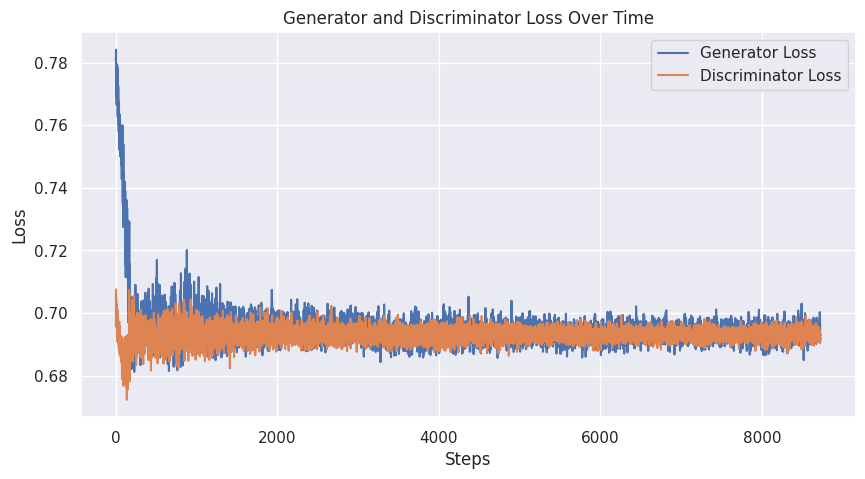

In [ ]:
plot_losses(gen_history, disc_history)

In [ ]:
def plot_generators_output(gen, real_data, num_points=1000):
    gen.eval()
    noise = get_noise(num_points, Z_DIM)
    fake_data = gen(noise).detach().cpu().numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(real_data[:, 0], real_data[:, 1], s=0.5, label="Original Data")
    plt.scatter(fake_data[:, 0], fake_data[:, 1], s=0.5, label="Generated Data")
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Original Data vs. Generated Data")
    plt.legend()
    plt.show()

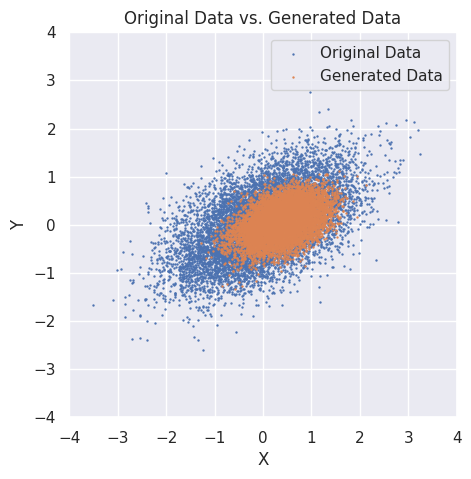

In [ ]:
plot_generators_output(gen, data, num_points=10000)